# Train and save model checkpoints

In [2]:
from ffcv.fields.decoders import IntDecoder, SimpleRGBImageDecoder
from ffcv.loader import Loader, OrderOption
from ffcv.pipeline.operation import Operation
from ffcv.transforms import RandomHorizontalFlip, Cutout, \
    RandomTranslate, Convert, ToDevice, ToTensor, ToTorchImage
from ffcv.transforms.common import Squeeze

import os
from pathlib import Path
import wget
from tqdm import tqdm
import numpy as np
import torch
from torch.cuda.amp import GradScaler, autocast
from torch.nn import CrossEntropyLoss, Conv2d, BatchNorm2d
from torch.optim import SGD, lr_scheduler
import torchvision

In [4]:
BETONS = {
        'train': "https://www.dropbox.com/s/zn7jsp2rl09e0fh/train.beton?dl=1",
        'val': "https://www.dropbox.com/s/4p73milxxafv4cm/val.beton?dl=1",
}

STATS = {
        'mean': [125.307, 122.961, 113.8575],
        'std': [51.5865, 50.847, 51.255]
}

def get_dataloader(batch_size=256,
                num_workers=8,
                split='train',  # split \in [train, val]
                aug_seed=0,
                should_augment=True,
                indices=None):
        label_pipeline: List[Operation] = [IntDecoder(),
                                        ToTensor(),
                                        ToDevice(torch.device('cuda:0')),
                                        Squeeze()]
        image_pipeline: List[Operation] = [SimpleRGBImageDecoder()]

        if should_augment:
                image_pipeline.extend([
                        RandomHorizontalFlip(),
                        RandomTranslate(padding=2, fill=tuple(map(int, STATS['mean']))),
                        Cutout(4, tuple(map(int, STATS['std']))),
                ])

        image_pipeline.extend([
            ToTensor(),
            ToDevice(torch.device('cuda:0'), non_blocking=True),
            ToTorchImage(),
            Convert(torch.float32),
            torchvision.transforms.Normalize(STATS['mean'], STATS['std']),
        ])

        beton_url = BETONS[split]
        beton_path = f'./{split}.beton'
        wget.download(beton_url, out=str(beton_path), bar=None)

        return Loader(beton_path,
                    batch_size=batch_size,
                    num_workers=num_workers,
                    order=OrderOption.SEQUENTIAL,
                    drop_last=False,
                    seed=aug_seed,
                    indices=indices,
                    pipelines={'image': image_pipeline, 'label': label_pipeline})


# Resnet9
class Mul(torch.nn.Module):
    def __init__(self, weight):
        super(Mul, self).__init__()
        self.weight = weight
    def forward(self, x): return x * self.weight


class Flatten(torch.nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)


class Residual(torch.nn.Module):
    def __init__(self, module):
        super(Residual, self).__init__()
        self.module = module
    def forward(self, x): return x + self.module(x)


def construct_rn9(num_classes=2):
    def conv_bn(channels_in, channels_out, kernel_size=3, stride=1, padding=1, groups=1):
        return torch.nn.Sequential(
                torch.nn.Conv2d(channels_in, channels_out, kernel_size=kernel_size,
                            stride=stride, padding=padding, groups=groups, bias=False),
                torch.nn.BatchNorm2d(channels_out),
                torch.nn.ReLU(inplace=True)
        )
    model = torch.nn.Sequential(
        conv_bn(3, 64, kernel_size=3, stride=1, padding=1),
        conv_bn(64, 128, kernel_size=5, stride=2, padding=2),
        Residual(torch.nn.Sequential(conv_bn(128, 128), conv_bn(128, 128))),
        conv_bn(128, 256, kernel_size=3, stride=1, padding=1),
        torch.nn.MaxPool2d(2),
        Residual(torch.nn.Sequential(conv_bn(256, 256), conv_bn(256, 256))),
        conv_bn(256, 128, kernel_size=3, stride=1, padding=0),
        torch.nn.AdaptiveMaxPool2d((1, 1)),
        Flatten(),
        torch.nn.Linear(128, num_classes, bias=False),
        Mul(0.2)
    )
    return model

def train(model, loader, lr=0.4, epochs=100, momentum=0.9, weight_decay=5e-4, lr_peak_epoch=5, label_smoothing=0.0):
    opt = SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    iters_per_epoch = len(loader)
    # Cyclic LR with single triangle
    lr_schedule = np.interp(np.arange((epochs+1) * iters_per_epoch),
                            [0, lr_peak_epoch * iters_per_epoch, epochs * iters_per_epoch],
                            [0, 1, 0])
    scheduler = lr_scheduler.LambdaLR(opt, lr_schedule.__getitem__)
    scaler = GradScaler()
    loss_fn = CrossEntropyLoss(label_smoothing=label_smoothing)

    for ep in range(epochs):
        model_count = 0
        for it, (ims, labs) in enumerate(loader):
            opt.zero_grad(set_to_none=True)
            with autocast():
                out = model(ims)
                loss = loss_fn(out, labs)

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            scheduler.step()

In [ ]:
os.makedirs('./checkpoints', exist_ok=True)

for i in tqdm(range(20), desc='Training models..'):
    model = construct_rn9().to(memory_format=torch.channels_last).cuda()
    loader_train = get_dataloader(batch_size=512, split='train')
    train(model, loader_train)
    
    torch.save(model.state_dict(), f'./checkpoints/sd_{i}.pt')

In [40]:
ckpt_files = list(Path('./checkpoints').rglob('*.pt'))
ckpts = [torch.load(ckpt, map_location='cpu') for ckpt in ckpt_files]

# Set up the TRAKer class

In [41]:
model = construct_rn9().to(memory_format=torch.channels_last).cuda()
model = model.eval()

In [44]:
from trak import TRAKer

traker = TRAKer(model=model,
                task='image_classification',
                proj_dim=1024,
                save_dir='/tmp/trak_scores',
                train_set_size=10_000)

Existing IDs in /tmp/trak_scores: []


# Compute TRAK features for train data

In [45]:
batch_size = 128
loader_train = get_dataloader(batch_size=batch_size, split='train')

In [46]:
from tqdm import tqdm  # for progress tracking

for model_id, ckpt in enumerate(tqdm(ckpts[:3])):
    traker.load_checkpoint(ckpt, model_id=model_id)
    for batch in loader_train:
        traker.featurize(batch=batch, num_samples=batch[0].shape[0])

traker.finalize_features()

Finalizing features for all model IDs..: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.23it/s]


# Compute TRAK scores for targets

In [47]:
loader_targets = get_dataloader(batch_size=batch_size, split='val')

In [48]:
for model_id, ckpt in enumerate(tqdm(ckpts[:3])):
    traker.start_scoring_checkpoint(ckpt,
                                    model_id=model_id,
                                    num_targets=len(loader_targets.indices))
    for batch in loader_targets:
        traker.score(batch=batch, num_samples=batch[0].shape[0])

scores = traker.finalize_scores()

Finalizing scores for all model IDs..: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 94.60it/s]

Saving scores in /tmp/trak_scores/scores/scores_394ca197-a6dc-436b-8863-7b800c29140d.npy


# Visualize the attributions!

In [49]:
from matplotlib import pyplot as plt

In [50]:
targets = [1, 2]  # let's look at two validation images
loader_targets = get_dataloader(batch_size=2, split='val', indices=targets, should_augment=False)

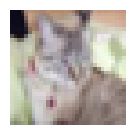

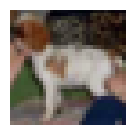

In [51]:
for batch in loader_targets:
    ims, _ = batch
    ims = (ims - ims.min()) / (ims.max() - ims.min())
    for image in ims:
        plt.figure(figsize=(1.5,1.5))
        plt.imshow(image.cpu().permute([1, 2, 0]).numpy()); plt.axis('off'); plt.show()

And the highest scoring examples in the train set according to TRAK

Top scorers for target 1


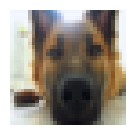

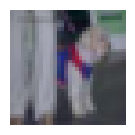

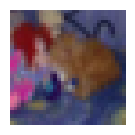

Top scorers for target 2


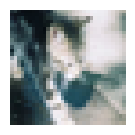

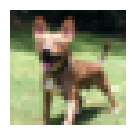

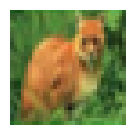

In [52]:
for target in targets:
    print(f'Top scorers for target {target}')
    loader_top_scorer = get_dataloader(batch_size=3, split='train', indices=scores[target].argsort()[-3:].cpu().numpy(), should_augment=False)
    for batch in loader_top_scorer:
        ims, _ = batch
        ims = (ims - ims.min()) / (ims.max() - ims.min())
        for image in ims:
            plt.figure(figsize=(1.5, 1.5))
            plt.imshow(image.cpu().permute([1, 2, 0]).numpy()); plt.axis('off'); plt.show()

# Extra: evaluate counterfactuals

We exactly follow the steps in https://docs.ffcv.io/ffcv_examples/cifar10.html, except for the fact that we replace the CIFAR-10 dataloader with the CIFAR-2 dataloader above. Additionally, we train on *subsets* of CIFAR-2, parametrized by the `masks` arrays below. We collect the model outputs for each retraining on a different subset (mask) in a separate array `margins`.

We train a total of 10,000 models. Note that this is not necessary to get TRAK scores. This step is only necessary to get (very high quality) LDS correlation estimates.

In [53]:
from scipy.stats import spearmanr

In [54]:
def eval_correlations(scores, tmp_path):
    masks_url = 'https://www.dropbox.com/s/2nmcjaftdavyg0m/mask.npy?dl=1'
    margins_url = 'https://www.dropbox.com/s/tc3r3c3kgna2h27/val_margins.npy?dl=1'

    masks_path = Path(tmp_path).joinpath('mask.npy')
    wget.download(masks_url, out=str(masks_path), bar=None)
    # num masks, num train samples
    masks = torch.as_tensor(np.load(masks_path, mmap_mode='r')).float()

    margins_path = Path(tmp_path).joinpath('val_margins.npy')
    wget.download(margins_url, out=str(margins_path), bar=None)
    # num , num val samples
    margins = torch.as_tensor(np.load(margins_path, mmap_mode='r'))

    val_inds = np.arange(2000)
    preds = masks @ scores
    rs = []
    ps = []
    for ind, j in tqdm(enumerate(val_inds)):
        r, p = spearmanr(preds[:, ind], margins[:, j])
        rs.append(r)
        ps.append(p)
    rs, ps = np.array(rs), np.array(ps)
    print(f'Correlation: {rs.mean()} (avg p value {ps.mean()})')
    return rs.mean()

In [55]:
eval_correlations(scores.cpu(), '.')

2000it [00:03, 512.51it/s]

Correlation: 0.06293852844167423 (avg p value 0.006028405998261695)


0.06293852844167423